In [1]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Ref L1aoXingyu

In [2]:
def load_data(ratio,look_back):
    # passengers number of international airline , 1949-01 ~ 1960-12 per month
    seq_number = np.array(
        [112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
         118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
         114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
         162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
         209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
         272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
         302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
         315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
         318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
         348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
         362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
         342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
         417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
         432.], dtype = np.float32)

    seq_number = seq_number[:, np.newaxis]

    max_value = np.max(seq_number)
    min_value = np.min(seq_number)
    scalar = max_value - min_value
    seq_number_scala = list(map(lambda x:x/scalar, seq_number))
    
    # 创建训练集
    data_X, data_Y = [],[]
    for i in range(len(seq_number_scala)-look_back):
        a = seq_number_scala[i:(i+look_back)]
        data_X.append(a)
        data_Y.append(seq_number_scala[i+look_back])
        
    # 划分训练集和测试集
    train_size = int(len(data_X)*ratio)
    test_size = len(data_X) - train_size
    train_X = data_X[:train_size]
    train_Y = data_Y[:train_size]
    test_X = data_X[train_size:]
    test_Y = data_Y[train_size:]
    

    return np.array(train_X),np.array(train_Y),np.array(test_X), np.array(test_Y), data_X,data_Y

In [3]:
tr_x, tr_y,te_x,te_y,data_X, data_Y = load_data(0.75,3)

print(len(tr_x))  # 训练集
print(len(tr_y)) # 测试集

105
105


In [4]:
# LSTM网络包装函数
class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(RegLSTM, self).__init__()

        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  # rnn
        #self.reg = nn.Sequential(
        #    nn.Linear(mid_dim, mid_dim),
        #    nn.Tanh(),
        #    nn.Linear(mid_dim, out_dim),
        #)  # regression
        self.reg = nn.Linear(mid_dim,out_dim)

        # x = feature
    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(seq_len*batch_size, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y

    """
    PyCharm Crtl+click nn.LSTM() jump to code of PyTorch:
    Examples::
        >>> rnn = nn.LSTM(10, 20, 2)
        >>> input = torch.randn(5, 3, 10)
        >>> h0 = torch.randn(2, 3, 20)
        >>> c0 = torch.randn(2, 3, 20)
        >>> output, (hn, cn) = rnn(input, (h0, c0))
    """

    def output_y_hc(self, x, hc):
        y, hc = self.rnn(x, hc)  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, hc

# Trainning

In [5]:
# 由本月的数据预测下一个月的数据

inp_dim = 4 #输入维度，指用多少历史数据,即上文load_data()中的look_back
out_dim = 1 # 输出维度1 
mod_dir = '.'

'''load data'''
ratio = 0.75
look_back = inp_dim
train_x,train_y,test_x,test_y,data_X,data_Y = load_data(ratio,look_back)
train_size = int(len(data_X)*ratio)

#需要将数据改变一下形状，因为 RNN 读入的数据维度是 (seq, batch, feature)，
#所以要重新改变一下数据的维度，这里只有一个序列，所以 batch 是 1，
# feature是一个seq里有几个数，这里是2

train_x = train_x.reshape((-1, 1, look_back)) # change from (N,3) to (N,1,3)
train_y = train_y.reshape((-1, 1, out_dim))
test_x = test_x.reshape((-1, 1,look_back))
test_y = test_y.reshape((-1, 1, out_dim))

'''build model'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = RegLSTM(inp_dim, out_dim, mid_dim=4, mid_layers=2).to(device) # mid_dim即隐藏层维度
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

'''train'''
var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
var_y = torch.tensor(train_y, dtype=torch.float32, device=device)
#var_x = Variable(torch.from_numpy(train_x))
#var_y = Variable(torch.from_numpy(train_y))
print('var_x.size():', var_x.size())
print('var_y.size():', var_y.size())

for e in range(2048):
    out = net(var_x)
    loss = criterion(out, var_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (e + 1) % 100 == 0:  # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
print('Model is ready!')
#torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))


var_x.size(): torch.Size([105, 1, 4])
var_y.size(): torch.Size([105, 1, 1])
Epoch: 100, Loss: 0.00502
Epoch: 200, Loss: 0.00516
Epoch: 300, Loss: 0.00345
Epoch: 400, Loss: 0.00190
Epoch: 500, Loss: 0.00137
Epoch: 600, Loss: 0.00092
Epoch: 700, Loss: 0.00076
Epoch: 800, Loss: 0.00066
Epoch: 900, Loss: 0.00076
Epoch: 1000, Loss: 0.00066
Epoch: 1100, Loss: 0.00049
Epoch: 1200, Loss: 0.00046
Epoch: 1300, Loss: 0.00045
Epoch: 1400, Loss: 0.00042
Epoch: 1500, Loss: 0.00041
Epoch: 1600, Loss: 0.00041
Epoch: 1700, Loss: 0.00040
Epoch: 1800, Loss: 0.00038
Epoch: 1900, Loss: 0.00037
Epoch: 2000, Loss: 0.00038
Model is ready!


# Evaluation

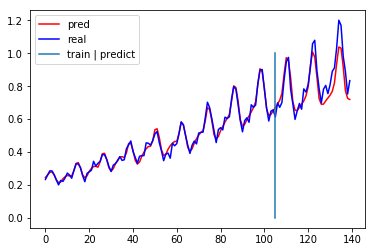

In [6]:
# 传统预测，给定输入后，基于过去的n帧状态，预测之后的1帧状态，全量预测
net  = net.eval()
data_X = np.array(data_X).reshape(-1,1,inp_dim)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X)
pred_test = net(var_data)

#%matplotlib auto
pred_test = pred_test.view(-1).data.numpy()
plt.plot(pred_test,'r',label = 'pred')
plt.plot(np.array(data_Y), 'b', label = 'real')
plt.plot([train_size, train_size], [0, 1], label='train | predict')
plt.legend()